# Tabula-based Q-learning with epsilon-greedy strategy (QTable-EG)

## Defining Agent

In [2]:
from collections import defaultdict
import gymnasium as gym
import numpy as np
import pickle
import flappy_bird_gymnasium


class QTable_EG_Agent:
    def __init__(
        self,
        env: gym.Env,
        learning_rate: float,
        initial_epsilon: float,
        epsilon_decay: float,
        final_epsilon: float,
        discount_factor: float = 0.95,
    ):
        """Initialize a Reinforcement Learning agent with an empty dictionary
        of state-action values (q_values), a learning rate and an epsilon.

        Args:
            env: The training environment
            learning_rate: The learning rate
            initial_epsilon: The initial epsilon value
            epsilon_decay: The decay for epsilon
            final_epsilon: The final epsilon value
            discount_factor: The discount factor for computing the Q-value
        """
        self.env = env
        self.q_values = defaultdict(lambda: np.zeros(env.action_space.n))

        self.lr = learning_rate
        self.discount_factor = discount_factor

        self.epsilon = initial_epsilon
        self.epsilon_decay = epsilon_decay
        self.final_epsilon = final_epsilon

        self.training_error = []

    def get_action(self, obs) -> int:
        """
        Returns the best action with probability (1 - epsilon)
        otherwise a random action with probability epsilon to ensure exploration.
        """
        # with probability epsilon return a random action to explore the environment
        if np.random.random() < self.epsilon:
            return self.env.action_space.sample()
        # with probability (1 - epsilon) act greedily (exploit)
        else:
            return int(np.argmax(self.q_values[obs]))

    def update(
        self,
        obs,
        action: int,
        reward: float,
        terminated: bool,
        next_obs,
    ):
        """Updates the Q-value of an action."""
        future_q_value = (not terminated) * np.max(self.q_values[next_obs])
        temporal_difference = (
            reward + self.discount_factor * future_q_value - self.q_values[obs][action]
        )

        self.q_values[obs][action] = (
            self.q_values[obs][action] + self.lr * temporal_difference
        )
        self.training_error.append(temporal_difference)

    def decay_epsilon(self):
        self.epsilon = max(self.final_epsilon, self.epsilon - self.epsilon_decay)

    def export_result(self, filename):
        result_path = "saved_policies/" + filename + ".pkl"

        with open(result_path, "wb") as f:
            pickle.dump(dict(self.q_values), f)

        print(f"Training results saved to {result_path}")


## Training Agent

### Prepare for training

In [21]:
# hyperparameters
learning_rate = 0.0001
n_episodes = 100_0000
start_epsilon = 1.0
epsilon_decay = start_epsilon / (n_episodes / 2)  # reduce the exploration over time
final_epsilon = 0.1

env = gym.make("FlappyBird-v0", render_mode=None, use_lidar=False)
env = gym.wrappers.RecordEpisodeStatistics(env, buffer_length=n_episodes)

agent = QTable_EG_Agent(
    env=env,
    learning_rate=learning_rate,
    initial_epsilon=start_epsilon,
    epsilon_decay=epsilon_decay,
    final_epsilon=final_epsilon,
)

### Training

In [22]:
from tqdm import tqdm

for episode in tqdm(range(n_episodes)):
    obs, info = env.reset()
    obs = [int(x) for x in obs]
    done = False

    # play one episode
    while not done:
        action = agent.get_action(tuple(obs))
        next_obs, reward, terminated, truncated, info = env.step(action)
        next_obs = [int(x) for x in next_obs]

        # update the agent
        agent.update(tuple(obs), action, reward, terminated, tuple(next_obs))

        # update if the environment is done and the current obs
        done = terminated or truncated
        obs = next_obs

    agent.decay_epsilon()

# Export results
agent.export_result("QTable-EG")

100%|██████████| 1000000/1000000 [21:46<00:00, 765.24it/s]

Training results saved to saved_policies/QTable-EG.pkl


## Benchmark policy

In [ ]:
env = gym.make("FlappyBird-v0", render_mode=None, use_lidar=False)

with open("./saved_policies/QTable-EG.pkl", "rb") as f:
    q_table = pickle.load(f)

n_episodes = 1000
rewards = []

for _ in range(n_episodes):
    obs, _ = env.reset()
    obs = [int(x) for x in obs]
    done = False
    total_reward = 0

    while not done:
        action = np.argmax(q_table[tuple(obs)])
        obs, reward, done, truncated, info = env.step(action)
        obs = [int(x) for x in obs]
        total_reward += reward

    rewards.append(total_reward)

mean_reward = np.mean(rewards)
variance_reward = np.var(rewards)

print(f"Mean reward over {n_episodes} episodes: {mean_reward}")
print(f"Variance of reward over {n_episodes} episodes: {variance_reward}")

env.close()

Mean reward over 1000 episodes: 4.137299999999997
Variance of reward over 1000 episodes: 0.08591870999999941


## Benchmark for DQN from bernardo

In [3]:
import torch
import torch.nn as nn
import numpy as np

env = gym.make("FlappyBird-v0", render_mode=None, use_lidar=False)

class DQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, output_dim)
   
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

policy_net = DQN(12, 2)
policy_net.load_state_dict(torch.load("./saved_policies/dqn_flappy_bird.pth"))
policy_net.eval()

episodes = 1000
all_rewards = []

for ep in range(episodes):
    print(ep)
    obs, _ = env.reset()
    episode_reward = 0.0
    done = False
    
    while not done:
        with torch.no_grad():
            obs_tensor = torch.tensor(obs, dtype=torch.float32).unsqueeze(0)
            q_values = policy_net(obs_tensor)
            action = int(q_values.argmax().item())
        
        obs, reward, terminated, truncated, info = env.step(action)
        episode_reward += reward
        done = terminated or truncated

    all_rewards.append(episode_reward)

mean_reward = np.mean(all_rewards)
var_reward = np.var(all_rewards)
print("Mean Reward:", mean_reward)
print("Variance of Reward:", var_reward)

env.close()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [10]:
from gymnasium.wrappers import RecordVideo

import torch
import torch.nn as nn
import numpy as np

env = gym.make("FlappyBird-v0", render_mode="rgb_array", use_lidar=False)
env = RecordVideo(env, video_folder="./videos", name_prefix="eval",
                  episode_trigger=lambda x: True)

class DQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, output_dim)
   
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

policy_net = DQN(12, 2)
policy_net.load_state_dict(torch.load("./saved_policies/dqn_flappy_bird.pth"))
policy_net.eval()

obs, _ = env.reset()
episode_reward = 0.0
done = False

while not done:
    with torch.no_grad():
        obs_tensor = torch.tensor(obs, dtype=torch.float32).unsqueeze(0)
        q_values = policy_net(obs_tensor)
        action = int(q_values.argmax().item())
    
    obs, reward, terminated, truncated, info = env.step(action)
    episode_reward += reward
    done = terminated or truncated

all_rewards.append(episode_reward)


env.close()

### Visualize training

AttributeError: 'RecordVideo' object has no attribute 'return_queue'

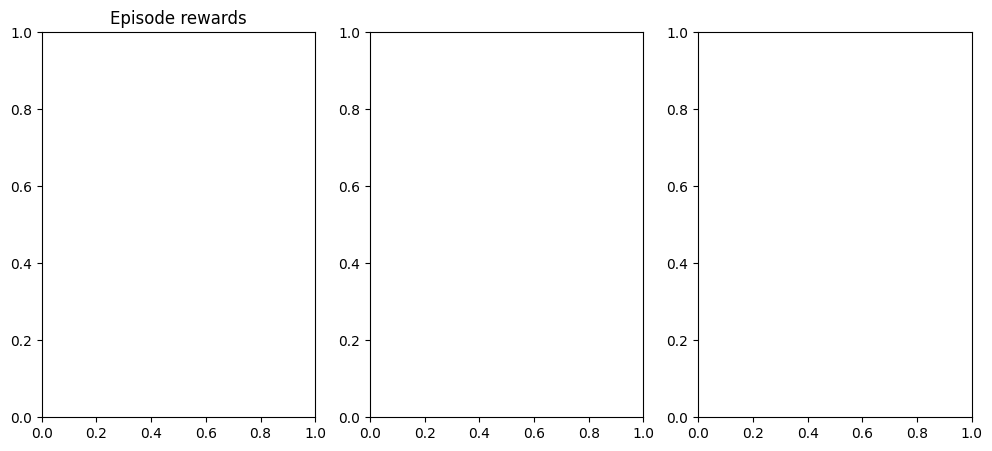

In [11]:
from matplotlib import pyplot as plt

def get_moving_avgs(arr, window, convolution_mode):
    return np.convolve(
        np.array(arr).flatten(),
        np.ones(window),
        mode=convolution_mode
    ) / window

# Smooth over a 500 episode window
rolling_length = 500
fig, axs = plt.subplots(ncols=3, figsize=(12, 5))

axs[0].set_title("Episode rewards")
reward_moving_average = get_moving_avgs(
    env.return_queue,
    rolling_length,
    "valid"
)
axs[0].plot(range(len(reward_moving_average)), reward_moving_average)

axs[1].set_title("Episode lengths")
length_moving_average = get_moving_avgs(
    env.length_queue,
    rolling_length,
    "valid"
)
axs[1].plot(range(len(length_moving_average)), length_moving_average)

axs[2].set_title("Training Error")
training_error_moving_average = get_moving_avgs(
    agent.training_error,
    rolling_length,
    "same"
)
axs[2].plot(range(len(training_error_moving_average)), training_error_moving_average)
plt.tight_layout()
plt.show()